# Classification of Citrus Diseases

> This notebook covers the necessary steps to experiment with a FLIM toward a classification problem. We will focus on Citrus leaf diseases, investigating a FLIM encoder combined with a fully connected layer to classify our images. Finally, we will replace fully connected layers with support vector machines (SVM). This approach enables us to train a pipeline end-to-end without backpropagation.

We will approach the following:

1. Split our data into training and testing;
2. Configure a dataset (With augmentations);
3. Configure our dataset as a data loader to provide data ingestion during the training phase;
4. Define a Model (Convolutional + Fully Connected);
5. Define a method to load FLIM-Encoder into our Classification model;
6. Define a training loop;
7. Define a testing loop;
8. Enable projection of activations (Convolutional and Fully Connected);
9. Run a training experiment and test our model;
10. Run a training experiment using SVM.

## 1. Split our data into training and testing;

Let us first define our dataset; we will explore the citrus leaf diseases, where we want to classify the disease given a leaf image. The cell below imports the necessary libraries.

In [1]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from random import shuffle
from skimage.color import lab2rgb, rgb2lab
import json

First, we need to define the path to our dataset. We are using the Citrus Disease dataset (images have a shape of 256x256 pixels with three channels). To run our experiments, we need to use either a GPU ("cuda") or a CPU ("cpu"); for such, we set the DEVICE variable.

We will also define the path to a JSON file which specifies our encoder architecture, and a folder with our endoder's weights.

In [2]:
DATA_PATH = Path("../data/citrus_leaves")
IMAGES_FOLDER = DATA_PATH / Path("orig_aug")
CLASSES_DESC = DATA_PATH / Path("classes.txt")

ARCH_JSON = Path(
    DATA_PATH / Path("flim_data/arch2d_class.json")
)

WEIGHTS_PATH = Path(
    DATA_PATH / Path("flim_data/model_bias_pca")
)

DEVICE = "cuda"

# Reads architecture dict to define our network
with open(ARCH_JSON, "r") as json_data:
    arch_description = json.load(json_data)

There is a text file describing each of our problem classes.

In [3]:
# Read classes to a dictionary
classes_dict = {}
with open(CLASSES_DESC, "r") as file:
    lines = file.readlines()
    for line in lines:
        class_id, class_description = line.strip().split(" ")
        classes_dict[int(class_id)] = class_description
        
print(classes_dict)

{1: 'blackspot', 2: 'canker', 3: 'greening', 4: 'healthy', 5: 'melanose'}


We have five classes:

1. Blackspot
2. Canker
3. Greening
4. Healthy
5. Melanose

Let's see the name of our images:

In [4]:
image_files = os.listdir(IMAGES_FOLDER)
print(image_files[:10])

['000004_000039.png', '000003_000013.png', '000002_000050.png', '000005_000036.png', '000001_000014.png', '000001_000003.png', '000002_000012.png', '000001_000041.png', '000003_000027.png', '000004_000019.png']


Looking at image folders, we could see that images are organized as follows:

xxxxxx_yyyyyy.png

Where,

- xxxxxx stands for image class;
- yyyyyy stands for image id.

For example, 000003_000024.png stands for an image of class 3 (greening), and 000004_000036.png for an image of class 4 (healthy).

As all images are organized in the same folder, we must split 70%-30% for training and testing, respectively, for each class. The cell below implements this division:

In [5]:
images_by_class = {
    1:[], 2:[], 3:[], 4:[], 5:[]
}

for image_file in image_files:
    image_class = int(image_file.split("_")[0])
    images_by_class[image_class].append(image_file)

    
train_images_by_class = {}
test_images_by_class = {}

for class_id, class_images in images_by_class.items():
    n_train_images = int(0.7 * len(class_images))
    train_images_by_class[class_id] = class_images[:n_train_images]
    test_images_by_class[class_id] = class_images[n_train_images:]

# Merge images back into a single list
train_images = []
for images in train_images_by_class.values():
    train_images += images
shuffle(train_images)
test_images = []
for images in test_images_by_class.values():
    test_images += images
shuffle(test_images)

## 2. Configure a dataset (With augmentations)

Now, we need to define the Dataset Class. It will:

1. Enable training and testing using our data splits.
2. Use augmentations. As we see in segmentation notebooks, sometimes a model performs well in training but poorly in testing. Hence, our model cannot generalize and present an overfitting on training data. A good practice to avoid it is using augmentations on the fly. Using augmentations enables us to modify images in different ways at each epoch;
3. Additionaly, we want our dataset to load our images in the lab color space.

We start by importing the necessary libraries.

In [6]:
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps
import random

First, to efficiently load LAB images we will use our C library (ift) through a python wrapper ([pyift](https://github.com/LIDS-UNICAMP/pyift)). The cell below executes the following:

1. We install the pyift wheel (Loacate at ../data/libs)
2. We create a symbolic link to the pyift.so

In [7]:
# Install the whl located on data
!python -m pip install ../data/libs/pyift-0.1-cp311-cp311-linux_x86_64.whl

# Get path to site-packages
import site
site_packages_path = site.getsitepackages()[0]
# Get absolute path
abs_path = os.path.realpath("../data/libs/pyift")

# Create Symbolick Link
!ln -s $abs_path/_pyift.*.so $site_packages_path/pyift/

ERROR: pyift-0.1-cp311-cp311-linux_x86_64.whl is not a supported wheel on this platform.
ln: target '/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/pyift/' is not a directory: No such file or directory


We start by importing the necessary libraries. As pyift to work with images in the LAB space.

In [8]:
# Import FLIM utils to load images as lab
import pyift.pyift as ift

Then, we define our dataset class:

In [9]:
class ClassificationDataset(Dataset):
    def __init__(
        self,
        images_folder: PosixPath, # Path to images
        images: List[str], # List of images
        augmentation: False # Augment or not input images
    ) -> None:
        self.images_path = [images_folder / Path(image) for image in images]
        self.augmentation = augmentation
        
        # Sets torch seed to guarantee Reproducibility
        self.random_seed = 7
        torch.manual_seed(self.random_seed)
        torch.cuda.manual_seed(self.random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        if self.augmentation == True:
            self.aug_transforms = transforms.Compose([
                transforms.RandomAffine(
                    degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                    interpolation=transforms.InterpolationMode.BILINEAR, 
                    fill=[0, 0.46726218, 0.5330766]
                ),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip()
            ])
            
        self.transformations = transforms.Compose([
                transforms.ToTensor(),
                transforms.ConvertImageDtype(torch.float32),
        ])
        
    def __len__(self):
        return len(self.images_path)
    
    def read_image_by_ift(self, image_path, augment=False):
        image = ift.ReadImageByExt(str(image_path))
        mimage = ift.ImageToMImage(image, color_space=ift.LABNorm2_CSPACE)
        lab_image = mimage.AsNumPy()
        lab_image = lab_image.squeeze()
        lab_image = self.transformations(lab_image)

        if augment == True:
            random.seed(self.random_seed)
            lab_image = self.aug_transforms(lab_image)
        
        return lab_image
    
    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        label_ = int(image_path.stem.split("_")[0])
        label_one_hot = np.zeros(5)
        label_one_hot[label_ - 1] = 1
        
        image = self.read_image_by_ift(image_path, augment=self.augmentation)
        
        label = torch.Tensor(label_one_hot)
        
        return image, label

Finnaly, we define our dataset using all training and testing data.

In [10]:
train_dataset = ClassificationDataset(
    images_folder=IMAGES_FOLDER,
    images=train_images,
    augmentation=True
)
# Augmentation is not necessary for our test data
test_dataset = ClassificationDataset(
    images_folder=IMAGES_FOLDER,
    images=test_images,
    augmentation=False
)

## 3. Configure our dataset as a dataloader

Finally, through PyTorch data loader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)), we configure our dataset as a data loader by using:

- A Dataset (Our Train and Test datasets);
- A batch size (Number of images used to update the model's parameters);
- If we want to shuffle our data at each epoch (We see images in different orders for each epoch).

In [11]:
# DATALOADERS - TRAIN AND TEST
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Visualizes shape of a batch sampled from train dataloder
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([8, 3, 256, 256])
Labels shape =>  torch.Size([8, 5])


Now, let us visualize the output of our dataloader object for a batch. The method `visualize_random_batch` enables us to see a random batch of our data loader:

In [12]:
def visualize_random_batch(dataloader):
    batch_images, batch_labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(2, 4, figsize=(16,8))
    for idx in range(8):
        image = batch_images[idx]
        image = image.permute(1, 2, 0)
        image = image.detach().cpu().numpy()
        image[:,:, 0] = image[:,:, 0] * 99.998337
        image[:,:, 1] = image[:,:, 1] * (86.182236 + 98.258614) - 86.182236
        image[:,:, 2] = image[:,:, 2] * (107.867744 + 94.481682) - 107.867744
        image = lab2rgb(image)
        label = batch_labels[idx]
        label = label.detach().cpu().numpy()
        label = np.argmax(label) + 1
        title = classes_dict[label]
        
        # Plot Data
        axes[idx//4][idx%4].set_yticks([]),axes[idx//4][idx%4].set_xticks([])
        axes[idx//4][idx%4].set_title(title)
        axes[idx//4][idx%4].imshow(image)

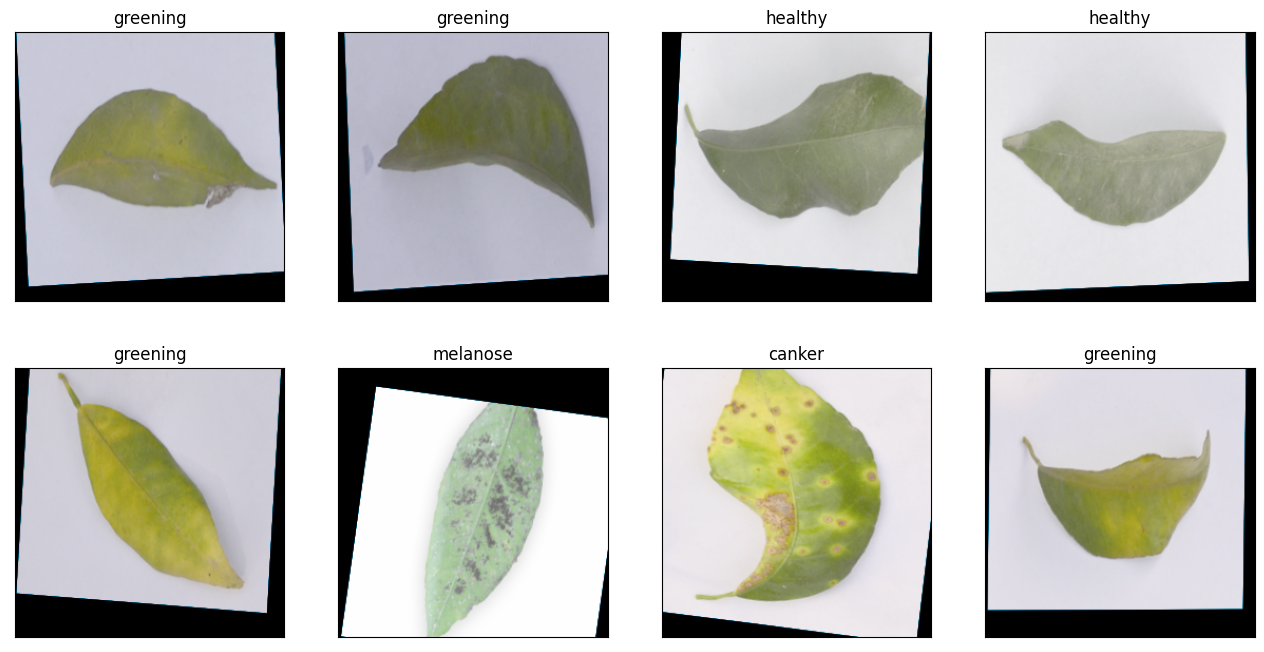

In [13]:
visualize_random_batch(train_dataloader)

## 4. Define a Model (Convolutional + Fully Connected)

First, we import necessary libraries.

In [14]:
import torch
from torch import nn
from tifffile import imsave
import torch_snippets

Let us first define a method to help us:

`conv`: Implements a convolutional block with ReLU and MaxPooling.

In [15]:
def conv(
        in_channels:int,
        out_channels:int,
        kernel_size:int,
        padding:int=1
) -> torch.nn.modules.container.Sequential:
    return nn.Sequential(
        nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=1, padding=padding),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
    )

Now, the class ClassificationModel defines our architecture:

1. On the **__init__** method, we first set a random_seed to guarantee reproducibility. Then, we define our encoder blocks (conv1, conv2, and conv2) and our decoder/classifier (Fully Connected, ReLU, and Droupout);
2. Our **forward** method passes the input image through the model architecture until we get the classification. Additionally, the method `torch.flatten` converts the encoder's output to a 2D tensor (batch, N);
3. **write_activation** and **save_activations** saves activations of each network block for visual inspection;
4. **save_curves** will save the learning curves of our models at the end of our training loop.

To initialize a Classification model, we must set the following parameters:

- `in_channels:` The number of channels of our input (e.g., 3 for RGB and 1 for Gray);
- `n_kernels:` A list of 3 integer values specifying the number of kernels for each convolutional block (e.g., [8, 16,32]).
- `kernel_sizes:` A list of 3 integer values, specifying the kernels' size for each convolutional block (e.g., [3, 3, 3]);
- `fc_neurons:` A list of 2 integers specifying the number of neurons for our 2 Fully-Connected Layers;
- `activations_path:` A path to save each convolutional block activation. After training, one could navigate into that folder to visualize what kind of features the model is extracting.

In [16]:
class ClassificationModel(nn.Module):
    def __init__(
        self, in_channels: int, # RGB or LAB -> 3 Channels
        n_kernels: List[int], # N Kernels by conv block
        kernel_sizes: List[int], # Kernel sizes by conv block
        fc_neurons: List[int], # N Neurons for FC (Fully Connected) Layers
        activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        self.activations_path = activations_path
        
        # Sets torch seed to guarantee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # Classification Encoder        
        self.conv1 = conv(
            in_channels=in_channels, out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],padding=kernel_sizes[0]//2
        )
        self.conv2 = conv(
            in_channels=n_kernels[0], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],padding=kernel_sizes[1]//2
        )
        self.conv3 = conv(
            in_channels=n_kernels[1], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],padding=kernel_sizes[2]//2
        )
        
        # Classification Decoder (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=32*32*n_kernels[2], out_features=fc_neurons[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=fc_neurons[0], out_features=fc_neurons[1]),
        )
        
        # Initialize weights (XAVIER)
        self._initialize_weights()
        
    def forward(self, x):
        # List to keep track of activations
        self.activations = []
        
        # Extract Features
        x = self.conv1(x)
        self.activations.append(x)
        x = self.conv2(x)
        self.activations.append(x)
        x = self.conv3(x)
        self.activations.append(x)
        
        #Flattens input tensor into a 2D tensor
        x = torch.flatten(x, start_dim=1)
        
        y = self.classifier(x)
        
        return y
        
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=np.sqrt(2. / n))
                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()
                    
    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)
        
        image = Image.fromarray(image)
        if reshape:
            image = image.resize((256, 256), Image.Resampling.NEAREST)
        image.save(path)
        
    # Save encoder activations
    @torch.no_grad()
    def save_activations(
        self, epoch: int,
        data_loader: torch.utils.data.dataloader.DataLoader
    ) -> None:
        activations_path = self.activations_path / Path(f"epoch_{epoch}")
        
        # Saving activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = image_path.stem
            saving_path = activations_path / Path(image_name) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name) / Path("encoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            
            image_data = data_loader.dataset.read_image_by_ift(image_path)
            # Adds Batch Dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)
            
            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]
                    
                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Save with the same shape as input
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )
                    
        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))
        
    def save_curves(self, logger: torch_snippets.torch_loader.Report) -> None:
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(["trn_loss"], ax=ax)
        savefig_path = self.activations_path / Path("loss.png")
        plt.savefig(savefig_path)
        
        _, ax = plt.subplots(figsize=(8, 6))
        logger.plot_epochs(["trn_accuracy"], ax=ax)
        savefig_path = self.activations_path / Path("accuracy.png")
        plt.savefig(savefig_path)

## 5. Define a method to load FLIM-Encoder into our Classification model

Additionally, as we will use a FLIM Encoder as our U-Net encoder, we define methods to load the FLIM Encoder's weight into the U-Net encoder.

The method `load_FLIM_encoder`, receives as parameters:

- `model`: Our U-Net model;
- `arch_json`: The path to a JSON file describing our FLIM-Encoder;
- `weights_path`: The path to a folder with the FLIM-Encoder's weights;
- `channels`: A list specifying the number of input channels (e.g., 3 for RGB) and the number of filters for each encoder convolutional block.

In [17]:
def get_bias(bias_path: PosixPath) -> np.ndarray:
    with open(bias_path, "r") as file:
        n_kernels = file.readline()
        bias = file.readline().strip().split(" ")
    
    bias = np.array(bias).astype(np.float32)
    
    return bias


def shift_weights(weights: np.ndarray, kernel_size: int, in_channels: int) -> np.ndarray:

    nkernels = weights.shape[1]
    
    shifted_weights = np.zeros((nkernels,in_channels,kernel_size[1],kernel_size[0]))    
   
    for k in range(nkernels): 
        for channel in range(in_channels):
            i = channel
            for row in range(kernel_size[1]):
                for col in range(kernel_size[0]):
                    shifted_weights[k][channel][row][col] = weights[i][k]
                    i = i + in_channels

    return shifted_weights


def get_weights(kernel_path: PosixPath,  kernel_size: int, in_channels: int) -> np.ndarray:
    weights = np.load(kernel_path)
    weights = shift_weights(weights, kernel_size, in_channels)
    
    return weights

def load_FLIM_encoder(
        model: ClassificationModel, arch_json: PosixPath, weights_path: PosixPath, channels: List[int]
) -> None:
    with open(arch_json, "r") as json_data:
        arch_description = json.load(json_data)
    
    n_layers = arch_description["nlayers"]
    
    in_channels = channels[0]
    print("[INFO] Loading FLIM Encoder")
    for n in range(1, n_layers + 1):
        out_channels = channels[n]

        print(f"[INFO] Loading Layer {n} weights")
        # Gets each encoder Block to set its weights and biases
        model_block = getattr(model, f"conv{n}")
        
        # Sets its biases
        bias_path = weights_path / Path(f"conv{n}-bias.txt")
        kernel_path = weights_path / Path(f"conv{n}-kernels.npy")
        # Get biases and set to model - Accessing conv block biases
        bias = get_bias(bias_path)
        bias = nn.Parameter(torch.from_numpy(bias).float())
        model_block[0].bias.data = bias.to(DEVICE)
        
        # Get kernel weights and set to model - Accessing conv block weights
        kernel_size = arch_description[f"layer{n}"]["conv"]["kernel_size"]
        weights = get_weights(kernel_path, kernel_size, in_channels)
        weights = nn.Parameter(torch.from_numpy(weights).float())
        model_block[0].weight.data = weights.to(DEVICE)
        
        in_channels = channels[n]

## 6. Define a training loop

We have everything prepared in our pipeline; we lack a training loop, which will feed data from the data loader to our model, and use the model's prediction to compute loss and update the model's parameter.

First, we import the necessary libraries:

In [18]:
from torch_snippets import optim, Report
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

Secondly, we define a loss function which we want to optimize. Those loss functions were calculated by comparing the model's predicted class with the ground-truth class mask. To optimize those loss functions is to classify more images correctly.

We will use [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Additionally, we could set different weights for each class, which helps tackle unbalanced or problematic classes.

> See our slide decks and the link provided for further details.

Our method `criterion` computes a loss and an accuracy for each batch. It also implements [weight decay](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab) and [l2 regularization](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization).

In [19]:
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1, 1, 1.5, 1, 1])).to(DEVICE)

# Loss Function with L2 Regularization
def criterion(model, preds, targets, loss_function):
    loss_scalar = loss_function(preds, targets)
    
    # Add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    loss_scalar += 0.0001 * l2_regularization # 0.0001 is the weight_decay
    # Compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1] # same as argmax
    target_labels = torch.max(targets, 1)[1] # same as argmax
    acc = torch.sum(pred_labels == target_labels)
    n = pred_labels.size(0)
    acc = acc/n
    
    return loss_scalar, acc

Finally, we define our training loop. For such, we must provide:

- The number of epochs to train our model;
- Our Classification Model;
- A data loader;
- Our learning rate (lr), which controls the size of updates in the models' parameters. A too-high value will cause instability, while a too-low value will result in slower training;
- Our loss function;
- And the `n_save_activations`, which controls when we save our convolution activations. For instance, currently, it writes activations for every 200 epochs.
- The `freeze_encoder` parameter. `False` allows our training loop to update the encoder's weights, while `True` does not allow it.
- The `use_lr_scheduler` parameter. `True` allows our training loop to use a learning rate scheduler, while `True` uses a fixed learning rate.

In [20]:
def train_loop(
    epochs, model, dataloader, lr, loss_function,
    n_save_activations=200, freeze_encoder=False, use_lr_scheduler=False
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if use_lr_scheduler:
        scheduler = lr_scheduler.LinearLR(
            optimizer, start_factor=1e-1, end_factor=1, total_iters=20, verbose=False
        )
    model.to(DEVICE)
    logger = Report(epochs)
    
    # Freeze encoder weights
    if freeze_encoder:
        model.conv1.requires_grad_(False)
        model.conv1.trainable = False
        model.conv2.requires_grad_(False)
        model.conv2.trainable = False
        model.conv3.requires_grad_(False)
        model.conv3.trainable = False
    
    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader:
            model.train()
            image, ground_truth = batch
            image = image.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            prediction = model(image)
            optimizer.zero_grad()
            
            # Gets Loss and Accuracy
            loss, acc = criterion(model, prediction, ground_truth, loss_function)
            losses.append(loss)
            accuracies.append(acc)
            
            loss.backward()
            optimizer.step()
        
        # At the end of the epoch, we tach a step in our LR Scheduler
        if use_lr_scheduler:
            scheduler.step()
        
        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))
        
        logger.record(
            epoch + 1,
            trn_loss=mean_loss.item(),
            trn_accuracy=mean_acc.item()
            )
        if ((epoch + 1) % n_save_activations) == 0:
            model.save_activations(epoch, dataloader)

    model.save_curves(logger)

## 7. Define a testing loop

First, we import necessary libraries

In [21]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

The cells below define a method to use our trained model and predict each image class. We also compute metrics between the predicted and the ground truth classes. The following metrics were computed:

- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
- [cohen kappa score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html)

Additionally, we also show a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). It is a well-known method to assess classification performance. The diagonal represents correct predictions, while other matrix elements indicate the number of images misclassified for each class (with the incorrect prediction).

Finally, a classification report also shows additional metrics, such as [precision, recall, and f1-score](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#precision-recall).

In [22]:
@torch.no_grad()
def predict_and_evaluate(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    dataset: str="test"
) -> None:
    images_path = data_loader.dataset.images_path
    preds_path = model.activations_path / Path(f"preds_{dataset}.csv")
    model.eval()
    
    preds_dict = {
        "image_filename": [],
        "ground_truth": [],
        "pred_label": [],
        "prediction": []
    }
    for image_path in tqdm(images_path):
        image_filename = image_path.stem
        ground_truth = int(image_filename.split("_")[0])
        
        image_data = data_loader.dataset.read_image_by_ift(image_path)
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to(DEVICE)
        prediction = model(image_data).cpu().detach().numpy()[0]
        predicted_label = np.argmax(prediction) + 1
        
        preds_dict["image_filename"].append(image_filename)
        preds_dict["ground_truth"].append(ground_truth)
        preds_dict["pred_label"].append(predicted_label)
        preds_dict["prediction"].append(prediction)
        
    df = pd.DataFrame.from_dict(preds_dict)
    df.to_csv(preds_path, index=False)
    
    # Computes metrics for Multiclass Classification
    print(f"[INFO] Metrics for {dataset} dataset")
    
    cohen_kappa = cohen_kappa_score(preds_dict["ground_truth"], preds_dict["pred_label"])
    print(f"[INFO] Cohen Kappa Score: {cohen_kappa:.3f}")
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[0]
    )
    axs[0].set_title("Confusion matrix (CM)")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[1],
        normalize="true", values_format=".0%"
    )
    axs[1].set_title("CM normalized by row")
    plt.show()
    
    report = classification_report(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        target_names=list(classes_dict.values())
    )
    print(report)

## 7. Enable projection of activations

We also want to visualize how our transformations (convolutions and fully connected layers) can extract a separable representation of our data. For such a will, we will implement the following:

1. For each image, we will pass it through our whole network;
2. We will store the data transformed after each operation;
3. Given our transformed data, we apply TSNE to extract a representation of our data in two dimensions;
4. We plot each data instance to visualize how separable they are.

In [23]:
from sklearn.manifold import TSNE
from collections import OrderedDict
from typing import Tuple, Dict

In [24]:
def get_each_output(
    model: ClassificationModel,
    x: torch.Tensor
) -> OrderedDict:
    # Empty dict
    output_by_layer = OrderedDict()
    
    # Saves CNN Outputs
    x = model.conv1(x)
    output_by_layer["cnn-1"] = x.clone().detach().cpu().numpy()
    x = model.conv2(x)
    output_by_layer["cnn-2"] = x.clone().detach().cpu().numpy()
    x = model.conv3(x)
    output_by_layer["cnn-3"] = x.clone().detach().cpu().numpy()
    
    #Flattens input tensor into a 2D tensor
    x = torch.flatten(x, start_dim=1)
    
    # Saves Classifier Outputs
    for layer_name, layer in model.classifier.named_children():
        x = layer.forward(x)
        output_by_layer[f"classifier-{layer_name}"] = x.clone().detach().cpu().numpy()
        
    return output_by_layer

def get_outputs(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader
) -> Tuple[OrderedDict, np.ndarray]:
    outputs_by_layer = None
    all_labels = None
    
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.clone().detach().cpu().numpy()
        labels = np.argmax(labels, axis=1) + 1
        
        outputs = get_each_output(model, inputs)
        
        # save the outputs
        if outputs_by_layer == None:
            outputs_by_layer = outputs
            all_labels = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate(
                    (outputs_by_layer[layer], outputs[layer]),
                    axis=0
                )
            all_labels = np.concatenate((all_labels, labels))
            
    return outputs_by_layer, all_labels

def visualize_layers_output(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    classes_dict: Dict[int, str],
    dataset: str="test"
) -> None:
    print(f"[INFO] Generating visualizations for {dataset} dataset")
    tsne = TSNE(perplexity=12, n_iter=5000)
    outputs_by_layer, all_labels = get_outputs(model, data_loader)
    
    legends = [f"{value} ({key})" for key, value in classes_dict.items()]    
    
    # Projects each layer output into a 2D Space
    cmap = plt.get_cmap('tab10')
    for layer in outputs_by_layer:
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        embedded = tsne.fit_transform(output)
        
        for i_label in range(1, 6):
            filtered_embedded = embedded[all_labels==i_label]
            filtered_labels = all_labels[all_labels==i_label]
            points_color = np.array([list(cmap(i_label - 1))] * len(filtered_embedded))
            plt.scatter(
                filtered_embedded[:, 0], filtered_embedded[:, 1],
                c= points_color,
                label=legends[i_label - 1]
            )
        plt.legend(
            loc="lower center", bbox_to_anchor=(0.5, -0.2),
            ncol=3, fancybox=True, shadow=True
        )
        plt.axis("off")
        plt.title(layer)
        plt.show()
           

## 8. Run a training experiments and test our models

The cell below defines our Classification model and loads FLIM-Encoder weights into it.

In [25]:
model = ClassificationModel(
    in_channels=3, 
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    fc_neurons=[256, 5],
    activations_path=DATA_PATH / Path("exper/FLIM_Frozen_Encoder")
).to(DEVICE)

load_FLIM_encoder(
    model=model,
    arch_json=ARCH_JSON,
    weights_path=WEIGHTS_PATH,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

summary(model, (3,256,256))

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 16, 256, 256]        448
|    └─ReLU: 2-2                         [-1, 16, 256, 256]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 128, 128]        --
├─Sequential: 1-2                        [-1, 32, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 32, 128, 128]        4,640
|    └─ReLU: 2-5                         [-1, 32, 128, 128]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 64, 64]          --
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-7                       [-1, 64, 64, 64]          18,496
|    └─ReLU: 2-8                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-9     

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 128, 128]        --
|    └─Conv2d: 2-1                       [-1, 16, 256, 256]        448
|    └─ReLU: 2-2                         [-1, 16, 256, 256]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 128, 128]        --
├─Sequential: 1-2                        [-1, 32, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 32, 128, 128]        4,640
|    └─ReLU: 2-5                         [-1, 32, 128, 128]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 64, 64]          --
├─Sequential: 1-3                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-7                       [-1, 64, 64, 64]          18,496
|    └─ReLU: 2-8                         [-1, 64, 64, 64]          --
|    └─MaxPool2d: 2-9                    [-1, 64, 32, 32]          --
├─Sequential: 1-4                        [-1, 5]                   --
|    └─

Then, we first train our model without updating the FLIM-Encoder.

EPOCH: 1.000  trn_loss: 2.064  trn_accuracy: 0.159  (1.27s - 125.39s remaining)
EPOCH: 2.000  trn_loss: 1.817  trn_accuracy: 0.195  (2.52s - 123.57s remaining)
EPOCH: 3.000  trn_loss: 1.782  trn_accuracy: 0.252  (3.76s - 121.53s remaining)
EPOCH: 4.000  trn_loss: 1.713  trn_accuracy: 0.275  (5.00s - 119.99s remaining)
EPOCH: 5.000  trn_loss: 1.614  trn_accuracy: 0.354  (6.24s - 118.48s remaining)
EPOCH: 6.000  trn_loss: 1.544  trn_accuracy: 0.352  (7.51s - 117.64s remaining)
EPOCH: 7.000  trn_loss: 1.445  trn_accuracy: 0.469  (8.78s - 116.69s remaining)
EPOCH: 8.000  trn_loss: 1.348  trn_accuracy: 0.485  (10.08s - 115.90s remaining)
EPOCH: 9.000  trn_loss: 1.282  trn_accuracy: 0.538  (11.35s - 114.76s remaining)
EPOCH: 10.000  trn_loss: 1.243  trn_accuracy: 0.566  (12.59s - 113.34s remaining)
EPOCH: 11.000  trn_loss: 1.187  trn_accuracy: 0.519  (13.84s - 111.97s remaining)
EPOCH: 12.000  trn_loss: 1.087  trn_accuracy: 0.680  (15.09s - 110.62s remaining)
EPOCH: 13.000  trn_loss: 1.035  

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 74271.44it/s]


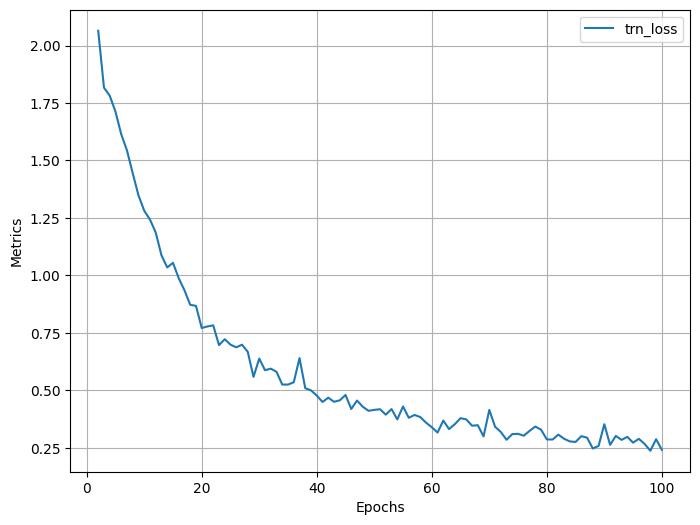

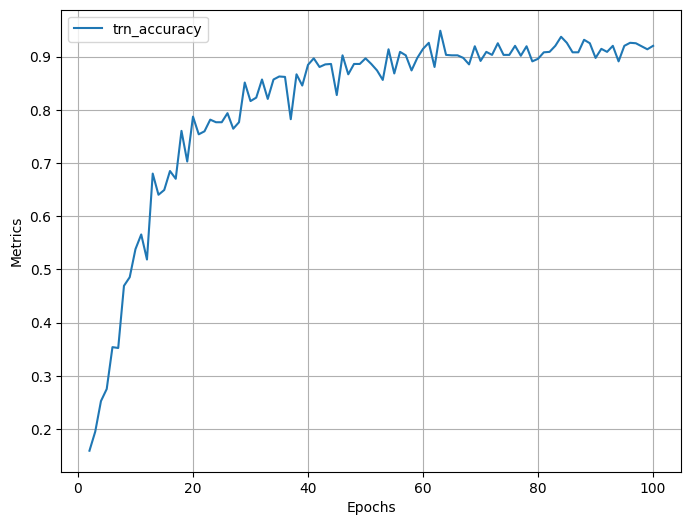

In [26]:
train_loop(
    100, model, train_dataloader, 1e-5, loss_function, 100,
    freeze_encoder=True, use_lr_scheduler=True
)

Now, we run our testing method (`predict_and_evaluate`) for the trained model, using the training and testing data.

100%|████████████████████████████████████████| 175/175 [00:01<00:00, 172.99it/s]


[INFO] Metrics for train dataset
[INFO] Cohen Kappa Score: 0.921


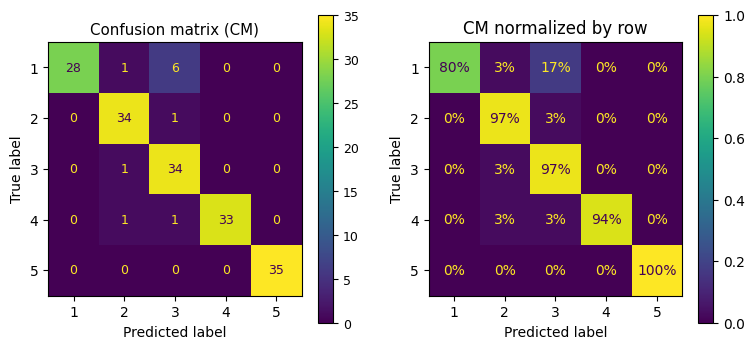

              precision    recall  f1-score   support

   blackspot       1.00      0.80      0.89        35
      canker       0.92      0.97      0.94        35
    greening       0.81      0.97      0.88        35
     healthy       1.00      0.94      0.97        35
    melanose       1.00      1.00      1.00        35

    accuracy                           0.94       175
   macro avg       0.95      0.94      0.94       175
weighted avg       0.95      0.94      0.94       175



In [27]:
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)

100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 171.79it/s]


[INFO] Metrics for test dataset
[INFO] Cohen Kappa Score: 0.867


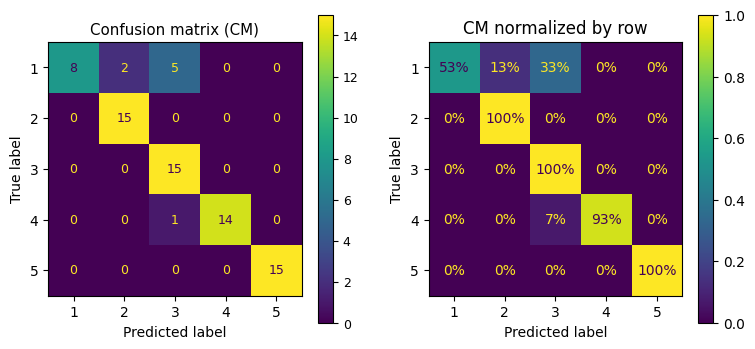

              precision    recall  f1-score   support

   blackspot       1.00      0.53      0.70        15
      canker       0.88      1.00      0.94        15
    greening       0.71      1.00      0.83        15
     healthy       1.00      0.93      0.97        15
    melanose       1.00      1.00      1.00        15

    accuracy                           0.89        75
   macro avg       0.92      0.89      0.89        75
weighted avg       0.92      0.89      0.89        75



In [28]:
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

We also visualize each layer's activations for training and test:

[INFO] Generating visualizations for Train dataset


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.43it/s]
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


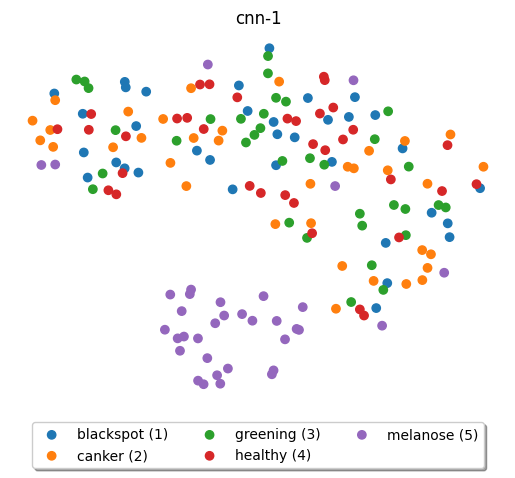

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


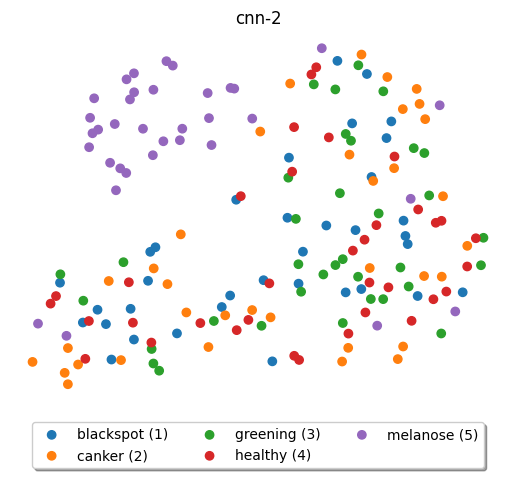

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


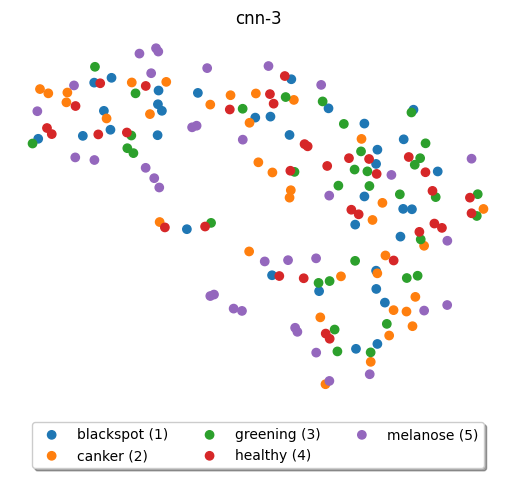

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


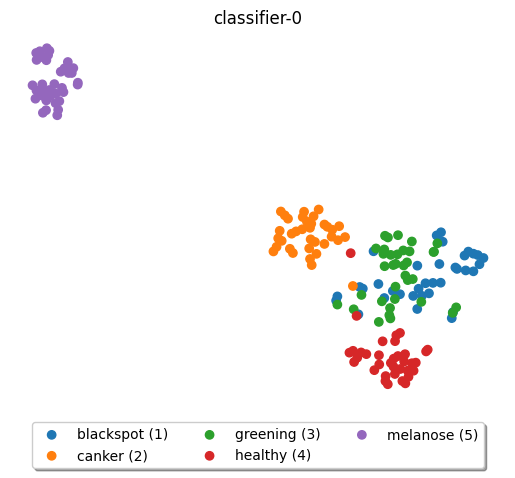

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


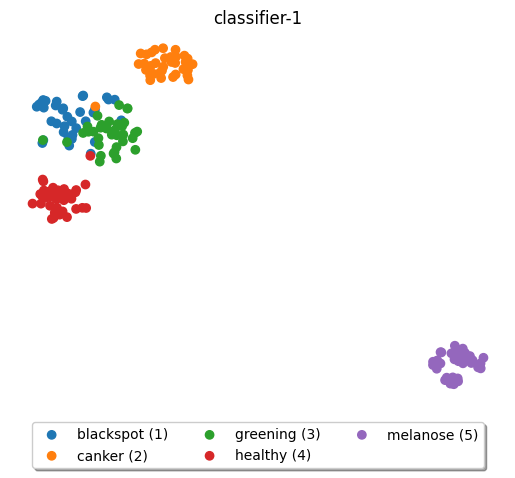

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


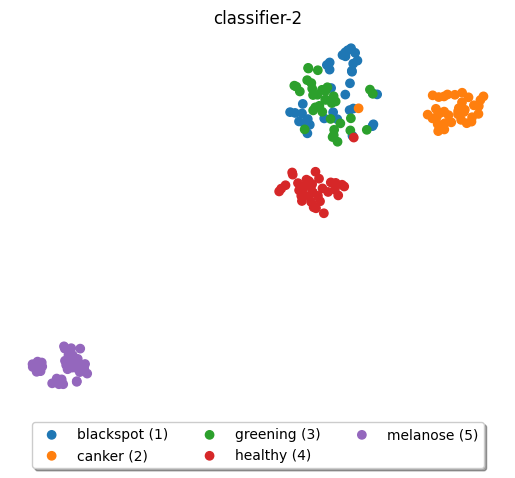

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


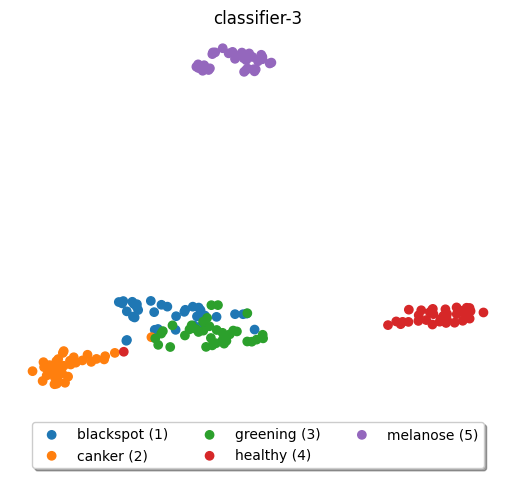

In [29]:
visualize_layers_output(
    model=model,
    data_loader=train_dataloader,
    classes_dict=classes_dict,
    dataset="Train"
)

[INFO] Generating visualizations for Test dataset


100%|███████████████████████████████████████████| 75/75 [00:01<00:00, 60.98it/s]
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


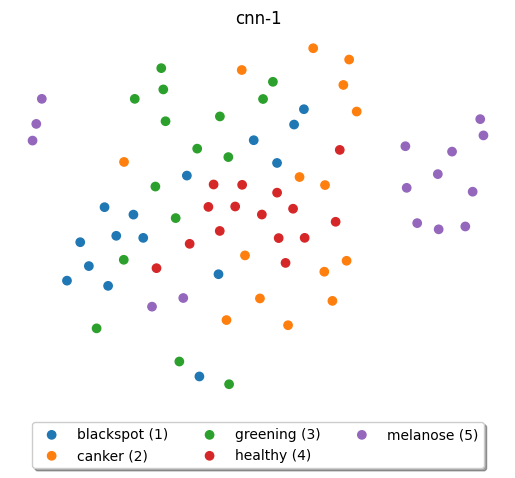

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


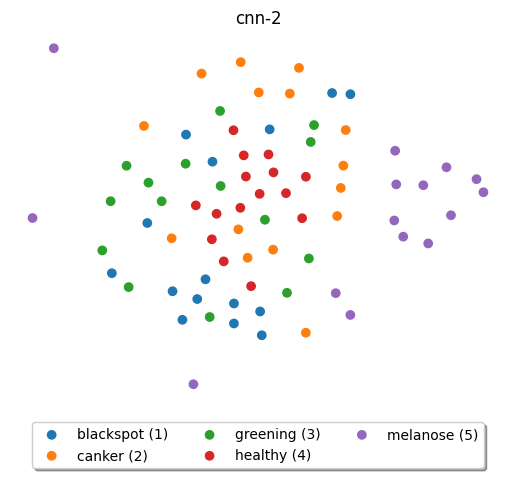

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


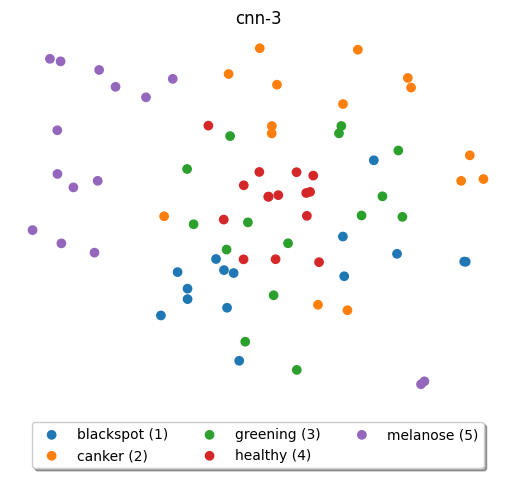

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


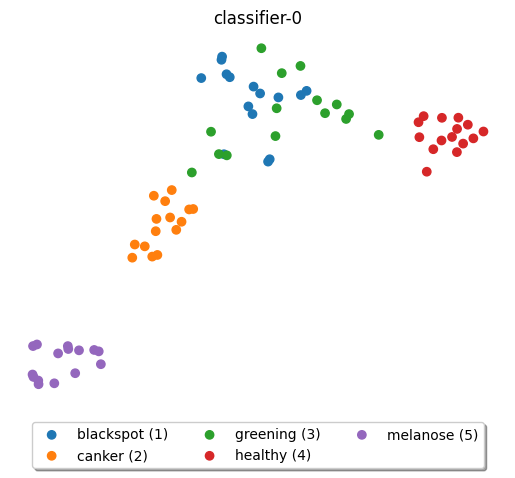

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


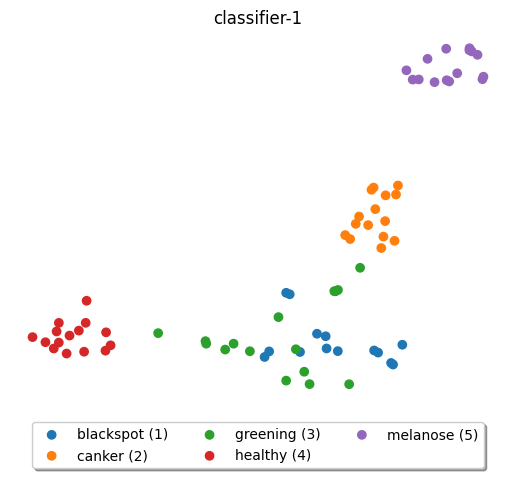

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


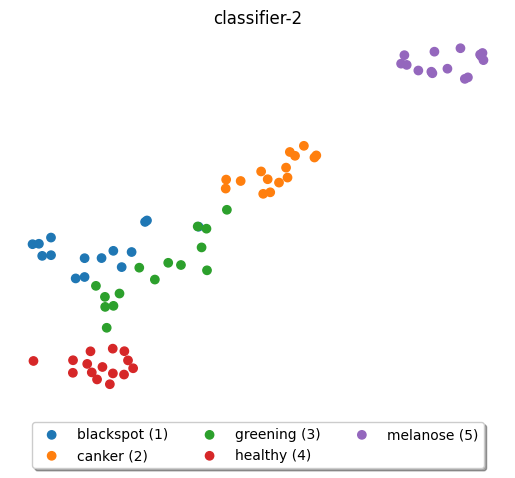

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


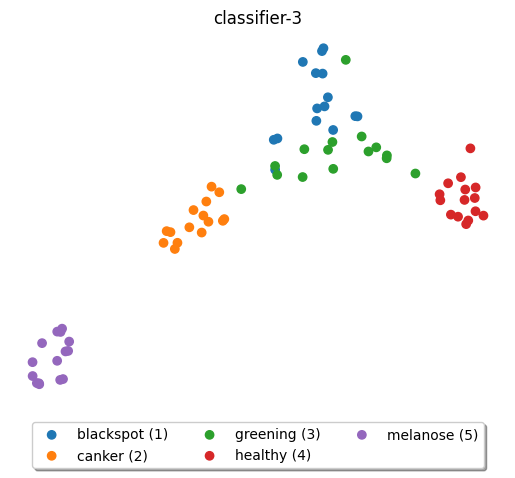

In [30]:
visualize_layers_output(
    model=model,
    data_loader=test_dataloader,
    classes_dict=classes_dict,
    dataset="Test"
)

____

Now, we define a new model and also load FLIM weights.

In [31]:
model = ClassificationModel(
    in_channels=3, 
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    fc_neurons=[256, 5],
    activations_path=DATA_PATH / Path("exper/FLIM_Unfrozen_Encoder")
)
load_FLIM_encoder(
    model=model,
    arch_json=ARCH_JSON,
    weights_path=WEIGHTS_PATH,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights


However, now, instead of not updating encoder Weights, we will use a learning rate scheduler to update its parameters.

EPOCH: 1.000  trn_loss: 1.907  trn_accuracy: 0.212  (1.32s - 131.10s remaining)
EPOCH: 2.000  trn_loss: 1.861  trn_accuracy: 0.184  (2.60s - 127.28s remaining)
EPOCH: 3.000  trn_loss: 1.753  trn_accuracy: 0.234  (3.87s - 125.27s remaining)
EPOCH: 4.000  trn_loss: 1.666  trn_accuracy: 0.377  (5.15s - 123.56s remaining)
EPOCH: 5.000  trn_loss: 1.525  trn_accuracy: 0.423  (6.49s - 123.23s remaining)
EPOCH: 6.000  trn_loss: 1.498  trn_accuracy: 0.468  (7.77s - 121.70s remaining)
EPOCH: 7.000  trn_loss: 1.456  trn_accuracy: 0.422  (9.05s - 120.24s remaining)
EPOCH: 8.000  trn_loss: 1.359  trn_accuracy: 0.508  (10.34s - 118.86s remaining)
EPOCH: 9.000  trn_loss: 1.287  trn_accuracy: 0.531  (11.62s - 117.54s remaining)
EPOCH: 10.000  trn_loss: 1.210  trn_accuracy: 0.577  (12.90s - 116.13s remaining)
EPOCH: 11.000  trn_loss: 1.131  trn_accuracy: 0.617  (14.18s - 114.76s remaining)
EPOCH: 12.000  trn_loss: 1.077  trn_accuracy: 0.628  (15.47s - 113.42s remaining)
EPOCH: 13.000  trn_loss: 1.014  

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 62522.63it/s]


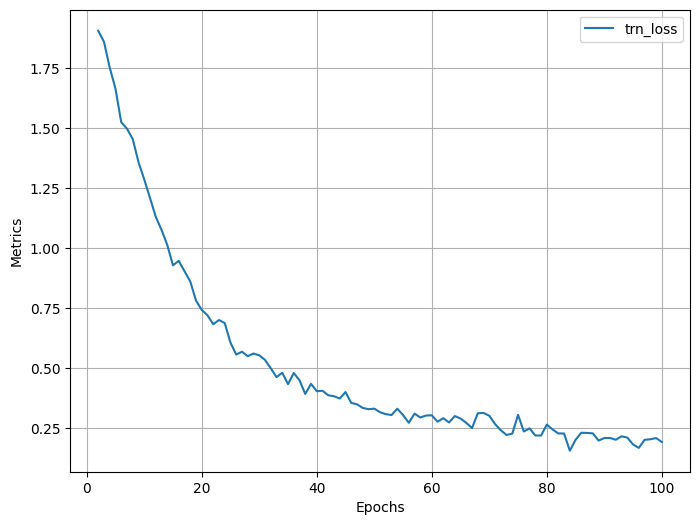

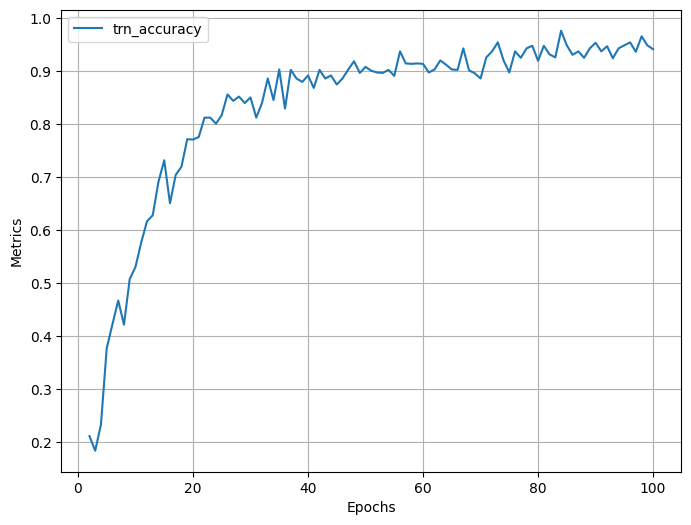

In [32]:
train_loop(
    100, model, train_dataloader, 1e-5, loss_function, 100,
    freeze_encoder=False, use_lr_scheduler=True
)

Finally, we also benchmark our model, and visualize its outputs:

100%|████████████████████████████████████████| 175/175 [00:01<00:00, 168.10it/s]


[INFO] Metrics for train dataset
[INFO] Cohen Kappa Score: 0.979


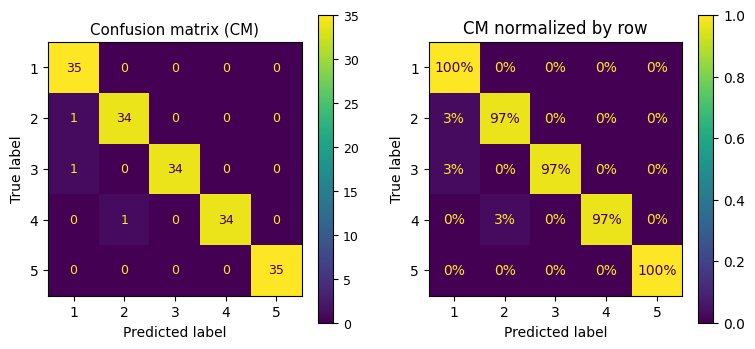

              precision    recall  f1-score   support

   blackspot       0.95      1.00      0.97        35
      canker       0.97      0.97      0.97        35
    greening       1.00      0.97      0.99        35
     healthy       1.00      0.97      0.99        35
    melanose       1.00      1.00      1.00        35

    accuracy                           0.98       175
   macro avg       0.98      0.98      0.98       175
weighted avg       0.98      0.98      0.98       175



In [33]:
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)

100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 173.39it/s]


[INFO] Metrics for test dataset
[INFO] Cohen Kappa Score: 0.950


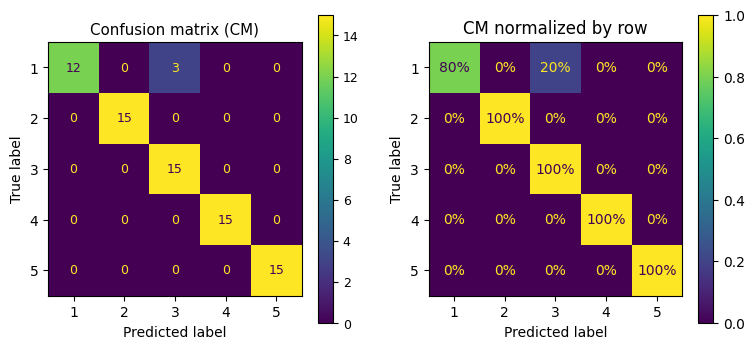

              precision    recall  f1-score   support

   blackspot       1.00      0.80      0.89        15
      canker       1.00      1.00      1.00        15
    greening       0.83      1.00      0.91        15
     healthy       1.00      1.00      1.00        15
    melanose       1.00      1.00      1.00        15

    accuracy                           0.96        75
   macro avg       0.97      0.96      0.96        75
weighted avg       0.97      0.96      0.96        75



In [34]:
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

[INFO] Generating visualizations for Train dataset


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 11.56it/s]
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


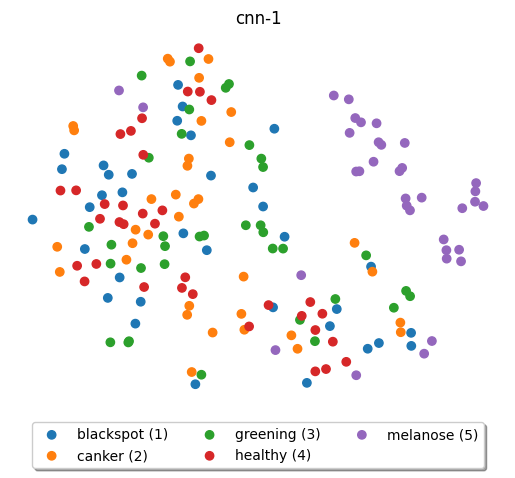

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


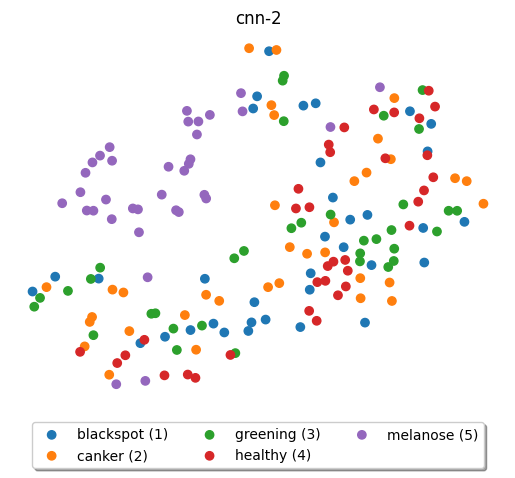

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


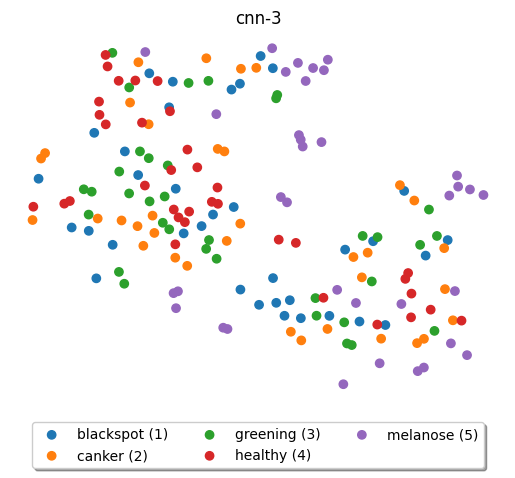

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


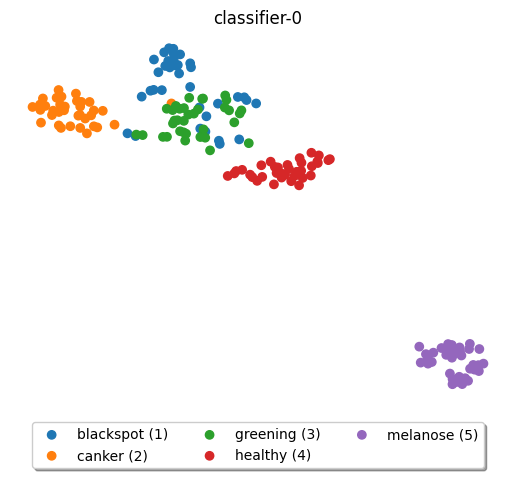

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


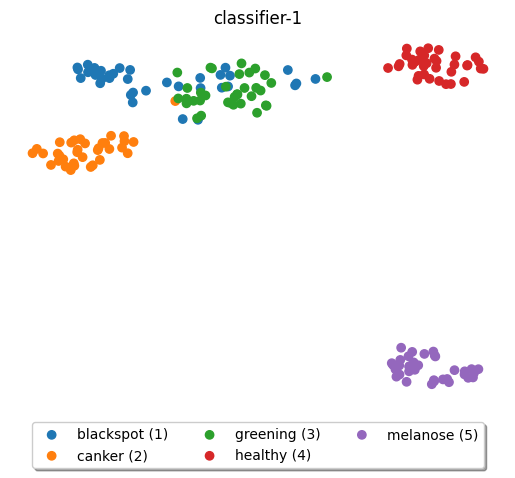

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


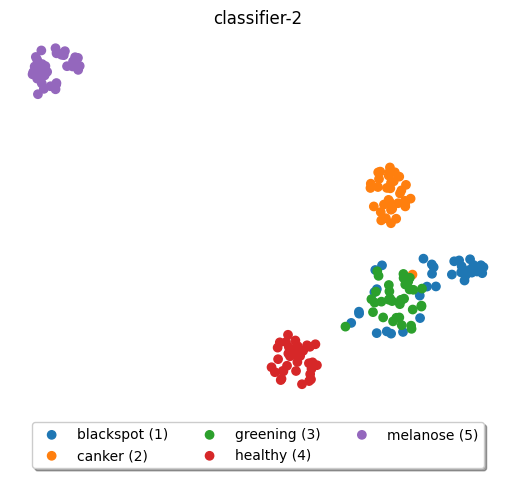

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


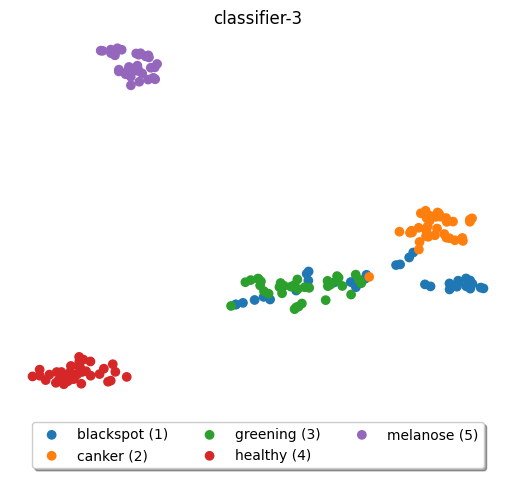

In [35]:
visualize_layers_output(
    model=model,
    data_loader=train_dataloader,
    classes_dict=classes_dict,
    dataset="Train"
)

[INFO] Generating visualizations for Test dataset


100%|███████████████████████████████████████████| 75/75 [00:01<00:00, 59.43it/s]
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


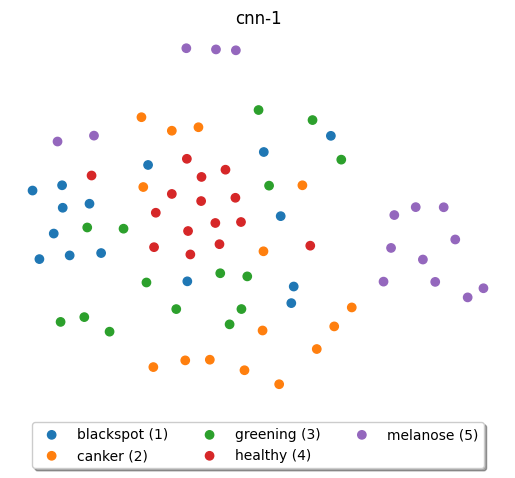

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


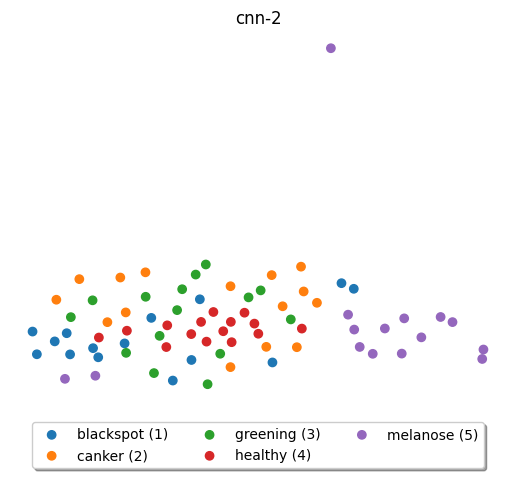

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


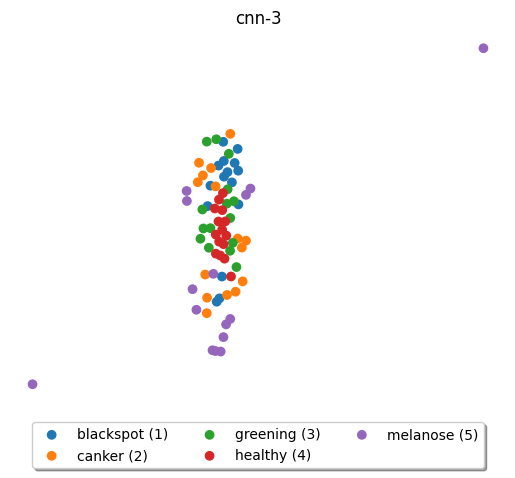

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


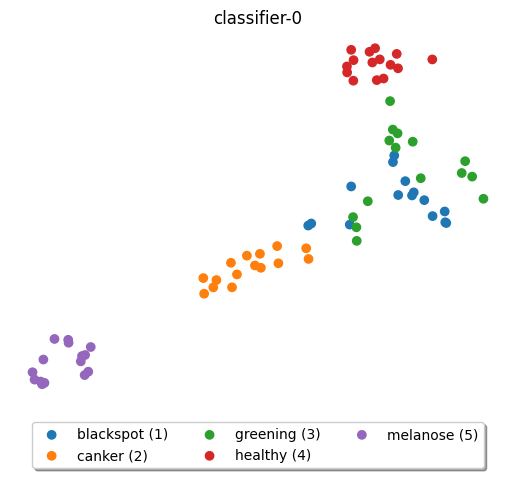

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


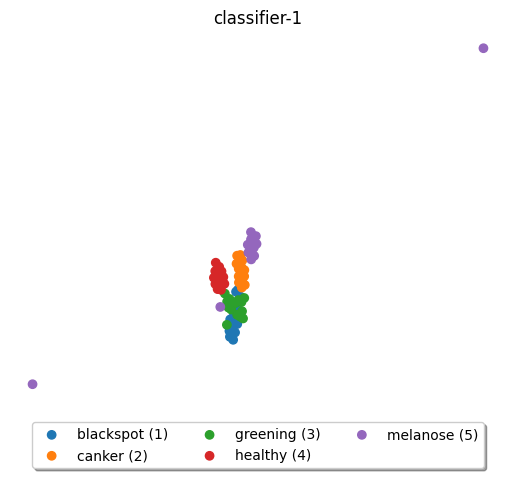

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


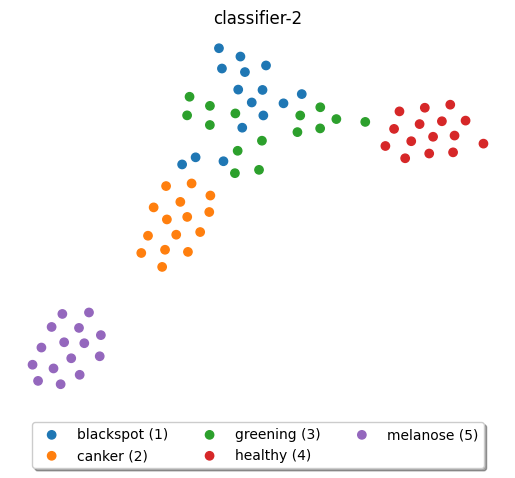

/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/afalcao/miniconda3/envs/mo445/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


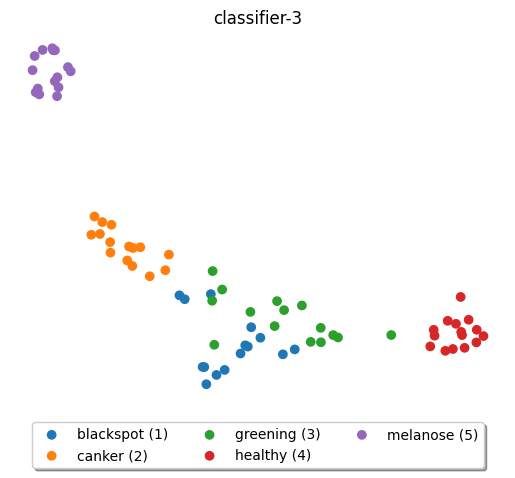

In [36]:
visualize_layers_output(
    model=model,
    data_loader=test_dataloader,
    classes_dict=classes_dict,
    dataset="Test"
)

## 10. Run a training experiment using SVM.

Finally, we will load our model and use an SVM to classify our images.

In [37]:
from sklearn import svm

Then, we define our model and load FLIM encoder again:

In [38]:
model = ClassificationModel(
    in_channels=3, 
    n_kernels=[
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ],
    kernel_sizes=[
        arch_description["layer1"]["conv"]["kernel_size"][0],
        arch_description["layer2"]["conv"]["kernel_size"][0], 
        arch_description["layer3"]["conv"]["kernel_size"][0]
    ],
    fc_neurons=[256, 5],
    activations_path=None
)
load_FLIM_encoder(
    model=model,
    arch_json=ARCH_JSON,
    weights_path=WEIGHTS_PATH,
    channels=[
        3,
        arch_description["layer1"]["conv"]["noutput_channels"],
        arch_description["layer2"]["conv"]["noutput_channels"],
        arch_description["layer3"]["conv"]["noutput_channels"]
    ] # [Input Channels, Kernels Layer 1, Kernels Layer 2, ....]
)

[INFO] Loading FLIM Encoder
[INFO] Loading Layer 1 weights
[INFO] Loading Layer 2 weights
[INFO] Loading Layer 3 weights


However, this time, we won't use our fully connected layers. Instead, we pass our input images through the encoder (convolutional blocks) and extract its features.

Then, based on the extracted features, we train an SVM model.

In [39]:
# Look for Falcão implementation
@torch.no_grad()
def train_svm(model, dataloader, max_iter=10000, C=1e2, degree=3):
    print("[INFO] Initializing SVM")
    clf = svm.SVC(
       max_iter=max_iter,
        C=C,
        degree=degree,
        gamma="auto",
        coef0=0,
        decision_function_shape="ovo",
        kernel="linear"
    )
    
    model.eval()
    model.to(DEVICE)
    
    features=torch.Tensor([])
    y = torch.Tensor([]).long()
    print("[INFO] Preparing Data to SVM")
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model.conv1(inputs)
        outputs = model.conv2(outputs)
        outputs = model.conv3(outputs).detach()

        features = torch.cat((features, outputs.cpu()))
        labels = labels.cpu().long()
        labels = np.argmax(labels, axis=1) + 1
        y = torch.cat((y, labels))
        
    print("[INFO] Fitting SVM")
    clf.fit(features.flatten(start_dim=1), y)
    
    print("[INFO] Done")
    
    return clf        

In [40]:
# Create a dataloader without augmentation
train_dataset_without_aug = ClassificationDataset(
    images_folder=IMAGES_FOLDER,
    images=train_images,
    augmentation=False
)
train_dataloader_without_aug = DataLoader(
    train_dataset_without_aug, batch_size=8, shuffle=False,
)
clf = train_svm(
    model=model,
    dataloader=train_dataloader_without_aug
)

[INFO] Initializing SVM
[INFO] Preparing Data to SVM


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 21.81it/s]


[INFO] Fitting SVM
[INFO] Done


Finally, we use our trained SVM to predict training and test images:

In [41]:
@torch.no_grad()
def evaluate_svm(model, clf, dataloader, dataset) -> None:
    model.eval()
    model.to(DEVICE)
    
    predictions = torch.Tensor([]).long()
    ground_truth = torch.Tensor([]).long()
    print("[INFO] Predicting with SVM")
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model.conv1(inputs)
        outputs = model.conv2(outputs)
        outputs = model.conv3(outputs).detach().cpu()
        outputs = outputs.flatten(start_dim=1)
        pred = clf.predict(outputs)

        labels = labels.cpu().long()
        labels = np.argmax(labels, axis=1) + 1
        ground_truth = torch.cat((ground_truth, labels))
        predictions = torch.cat((predictions, torch.Tensor(pred)))
    
    # Computes metrics for Multiclass Classification
    print(f"[INFO] Metrics for {dataset} dataset")
    cohen_kappa = cohen_kappa_score(ground_truth, predictions)
    print(f"[INFO] Cohen Kappa Score: {cohen_kappa:.3f}")
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(
        ground_truth,
        predictions,
        ax=axs[0]
    )
    axs[0].set_title("Confusion matrix (CM)")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(
        ground_truth,
        predictions,
        ax=axs[1],
        normalize="true", values_format=".0%"
    )
    axs[1].set_title("CM normalized by row")
    plt.show()
    
    report = classification_report(
        ground_truth,
        predictions,
        target_names=list(classes_dict.values())
    )
    print(report)

[INFO] Predicting with SVM


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 14.65it/s]


[INFO] Metrics for train dataset
[INFO] Cohen Kappa Score: 1.000


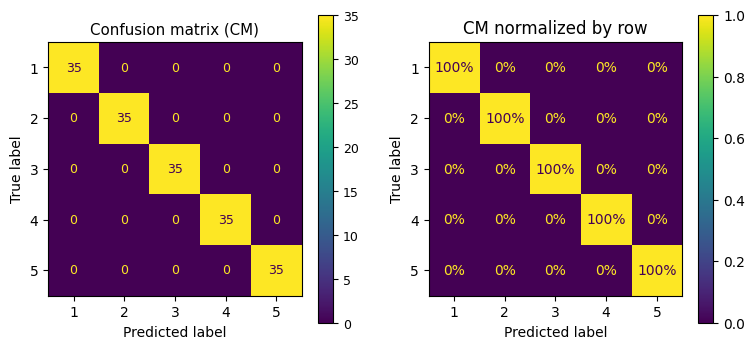

              precision    recall  f1-score   support

   blackspot       1.00      1.00      1.00        35
      canker       1.00      1.00      1.00        35
    greening       1.00      1.00      1.00        35
     healthy       1.00      1.00      1.00        35
    melanose       1.00      1.00      1.00        35

    accuracy                           1.00       175
   macro avg       1.00      1.00      1.00       175
weighted avg       1.00      1.00      1.00       175



In [42]:
evaluate_svm(model=model, clf=clf, dataloader=train_dataloader_without_aug, dataset="train")

[INFO] Predicting with SVM


100%|███████████████████████████████████████████| 75/75 [00:00<00:00, 98.65it/s]


[INFO] Metrics for test dataset
[INFO] Cohen Kappa Score: 0.833


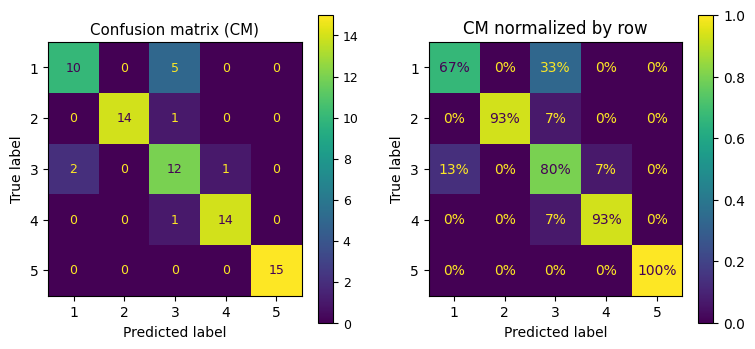

              precision    recall  f1-score   support

   blackspot       0.83      0.67      0.74        15
      canker       1.00      0.93      0.97        15
    greening       0.63      0.80      0.71        15
     healthy       0.93      0.93      0.93        15
    melanose       1.00      1.00      1.00        15

    accuracy                           0.87        75
   macro avg       0.88      0.87      0.87        75
weighted avg       0.88      0.87      0.87        75



In [43]:
evaluate_svm(model=model, clf=clf, dataloader=test_dataloader, dataset="test")

As we can see, multiple runs are needed to achieve a conclusion since the results may change due to the on-the-fly data augmentation. Data augmentation does not work for SVM since it uses a single epoch. One can also improve the results by exploring better image selection for marker drawing, markers, and architectures.

# Extra - Activities

- Modify augmentations, or test without it, and verify model's performance.
- Test different configurations for fully connected layers.
- Test different configurations for SVM
- Test different classifiers (e.g., Decision Trees)